In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications import ResNet50, EfficientNetB0, efficientnet_v2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_preprocess


In [3]:
# 2) SET PATHS AND PARAMETERS
# =========================================================
# Code from: Paper_aish.ipynb
DATASET_DIR = '/Users/aishwarysinghrathour/Desk/Data Sets/Kidney Dataset'

train_dir = os.path.join(DATASET_DIR, "train")
val_dir   = os.path.join(DATASET_DIR, "valid")
test_dir  = os.path.join(DATASET_DIR, "test")

img_size = (224, 224)
batch_size = 32

In [4]:
# 3) DATA ANALYSIS: COUNT AND PLOT IMAGE DISTRIBUTION
# =========================================================
# Code from: Paper_aish.ipynb
def count_images(folder):
    counts = {}
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print("Train counts:", train_counts)
print("Validation counts:", val_counts)
print("Test counts:", test_counts)


Train counts: {'Tumor': 1599, 'Cyst': 2597, 'Stone': 963, 'Normal': 3553}
Validation counts: {'Tumor': 342, 'Cyst': 556, 'Stone': 207, 'Normal': 762}
Test counts: {'Tumor': 342, 'Cyst': 556, 'Stone': 207, 'Normal': 762}


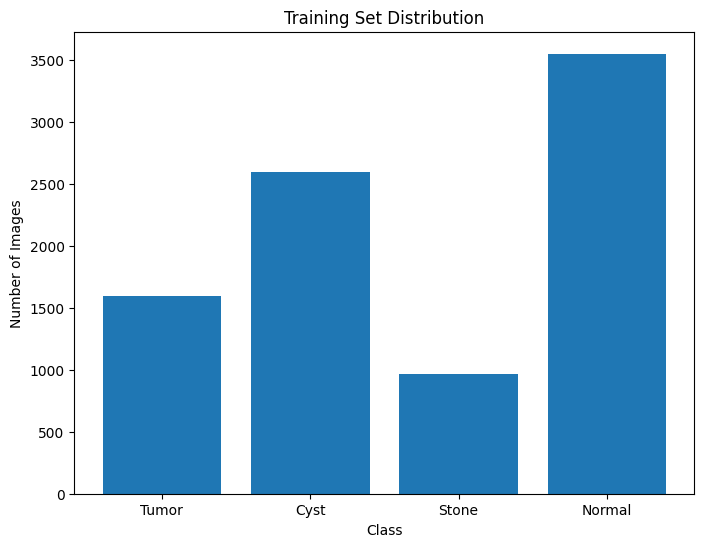

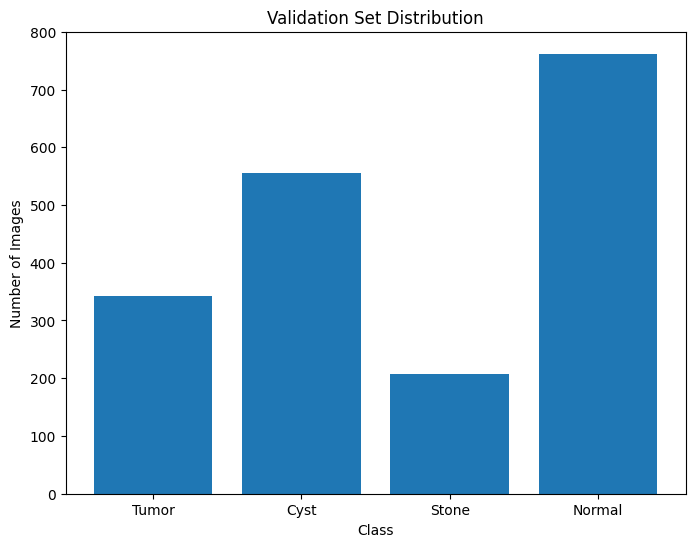

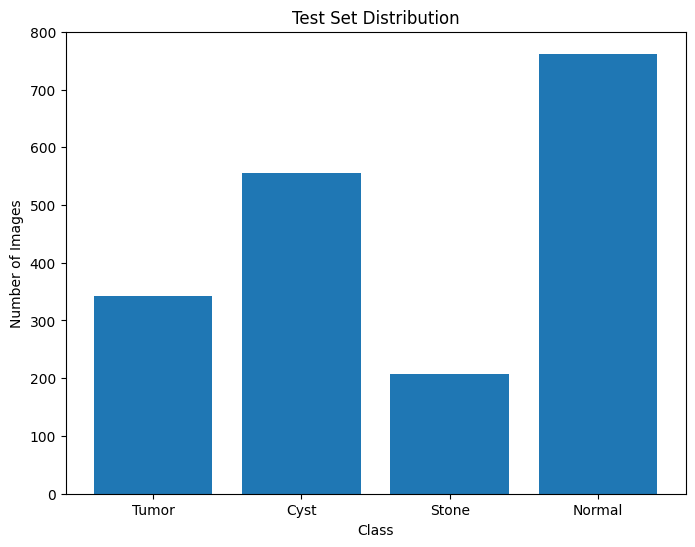

In [5]:
# Code from: Paper_aish.ipynb
def plot_distribution(counts, title):
    plt.figure(figsize=(8, 6))
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

plot_distribution(train_counts, "Training Set Distribution")
plot_distribution(val_counts, "Validation Set Distribution")
plot_distribution(test_counts, "Test Set Distribution")


In [6]:
# 4) DATA PREPARATION PIPELINE
# =========================================================
# Load dataset
# Code from: Paper_aish.ipynb
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Data augmentation pipeline (with added translation to improve robustness)
# This is an enhanced version based on the code from: Paper_aish.ipynb
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.20),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Added for robustness
])

# Apply augmentation to training data
# Code from: Paper_aish.ipynb
def prepare_dataset(dataset, training=False):
    if training:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    return dataset

train_ds_aug = prepare_dataset(train_ds, training=True)

# Apply prefetching for performance
# Code from: Paper_aish.ipynb
AUTOTUNE = tf.data.AUTOTUNE
train_ds_prefetched = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_prefetched   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_prefetched  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Compute class weights for imbalanced dataset
# Code from: Paper_aish.ipynb
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())
all_labels = np.array(all_labels)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)



Found 8712 files belonging to 4 classes.


2025-09-27 18:28:20.628297: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-27 18:28:20.628396: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-27 18:28:20.628405: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-27 18:28:20.628635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-27 18:28:20.628660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 1867 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Class Weights: {0: 0.8386599922988063, 1: 0.6130030959752322, 2: 2.2616822429906542, 3: 1.3621013133208255}


2025-09-27 18:28:31.462592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# MODEL 1: IMPROVED CUSTOM CNN
# =========================================================
# Increased dropout and regularization to reduce overfitting
# This is an enhanced version based on the code from: Paper_aish.ipynb
def build_improved_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.6),
        layers.Conv2D(64, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.65),
        layers.Conv2D(128, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.7),  # Increased dropout
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.8),  # Increased dropout
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # Increased regularization
        layers.Dropout(0.75), # Increased dropout
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- Build, Compile, and Train Model 1 ---
improved_cnn_model = build_improved_cnn((224, 224, 3), num_classes)
improved_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
improved_cnn_model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
print("\n--- Training Improved Custom CNN Model ---")
history_cnn = improved_cnn_model.fit(
    train_ds_prefetched,
    validation_data=val_ds_prefetched,
    epochs=25, # Increased epochs slightly as EarlyStopping will prevent overfitting
    class_weight=class_weights,
    callbacks=callbacks
)



--- Training Improved Custom CNN Model ---
Epoch 1/25


2025-09-26 21:46:10.804118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-09-26 21:46:21.602520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 175 of 1000
2025-09-26 21:46:26.997410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 ━━━━━━━━━━━━━━━━━━━━ 139s 441ms/step - accuracy: 0.4728 - loss: 1.8924 - val_accuracy: 0.2978 - val_loss: 34.1417 - learning_rate: 0.0010
Epoch 2/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 117s 429ms/step - accuracy: 0.5787 - loss: 1.1917 - val_accuracy: 0.2978 - val_loss: 28.5800 - learning_rate: 0.0010
Epoch 3/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 127s 466ms/step - accuracy: 0.6111 - loss: 1.0534 - val_accuracy: 0.2978 - val_loss: 32.4166 - learning_rate: 0.0010
Epoch 4/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 139s 506ms/step - accuracy: 0.6420 - loss: 0.9653 - val_accuracy: 0.1109 - val_loss: 27.7876 - learning_rate: 0.0010
Epoch 5/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 143s 521ms/step - accuracy: 0.6701 - loss: 0.9085 - val_accuracy: 0.2159 - val_loss: 22.2104 - learning_rate: 0.0010
Epoch 6/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 131s 477ms/step - accuracy: 0.6988 - loss: 0.8528 - val_accuracy: 0.1189 - val_loss: 36.4004 - learning_rate: 0.0010
Epoch 7/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 125s 458ms/step - accuracy: 0


--- Evaluating Improved Custom CNN Model ---
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2496 - loss: 19.9316
Test Accuracy: 0.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━

2025-09-26 22:11:54.516936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


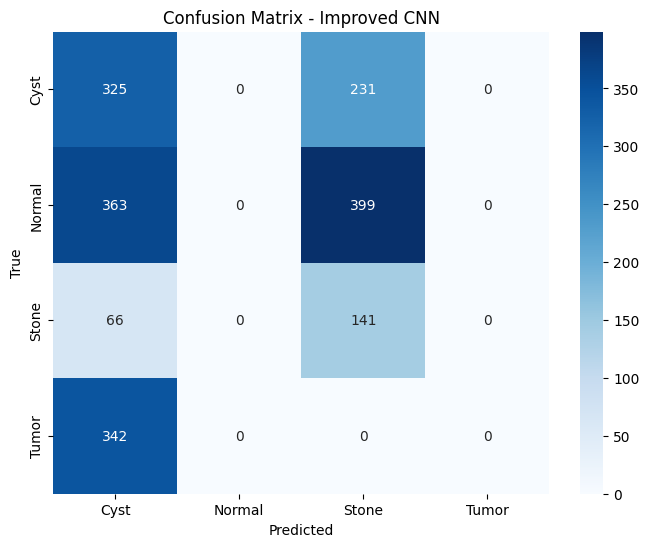


Classification Report - Improved CNN:
              precision    recall  f1-score   support

        Cyst       0.30      0.58      0.39       556
      Normal       0.00      0.00      0.00       762
       Stone       0.18      0.68      0.29       207
       Tumor       0.00      0.00      0.00       342

    accuracy                           0.25      1867
   macro avg       0.12      0.32      0.17      1867
weighted avg       0.11      0.25      0.15      1867



/opt/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

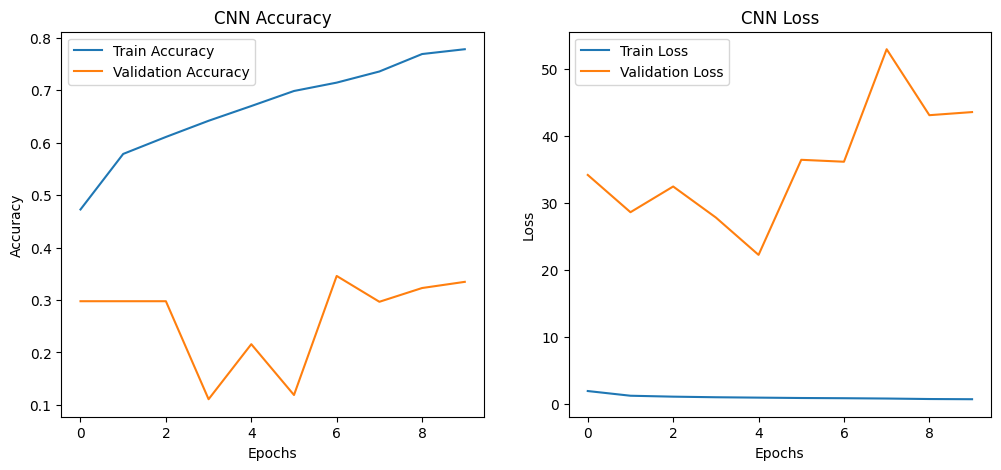

In [8]:
# --- Evaluate Model 1 ---
print("\n--- Evaluating Improved Custom CNN Model ---")
test_loss_cnn, test_acc_cnn = improved_cnn_model.evaluate(test_ds_prefetched)
print(f"Test Accuracy: {test_acc_cnn:.2f}")

# --- Plotting and Reporting for Model 1 ---
y_true_cnn, y_pred_cnn = [], []
for x, y in test_ds_prefetched:
    preds = improved_cnn_model.predict(x)
    y_true_cnn.extend(y.numpy())
    y_pred_cnn.extend(np.argmax(preds, axis=1))

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Improved CNN")
plt.show()

print("\nClassification Report - Improved CNN:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Loss")
plt.legend()
plt.show()

In [10]:
# MODEL 2: TRANSFER LEARNING (ResNet50) for Grayscale
# =========================================================
print("\n--- Preparing Data for Transfer Learning Models ---")
# --- 1. Load grayscale datasets ---
train_ds_gray = image_dataset_from_directory(
    train_dir, image_size=(224, 224), batch_size=32, color_mode="grayscale", label_mode="int"
)
val_ds_gray = image_dataset_from_directory(
    val_dir, image_size=(224, 224), batch_size=32, color_mode="grayscale", label_mode="int"
)
test_ds_gray = image_dataset_from_directory(
    test_dir, image_size=(224, 224), batch_size=32, color_mode="grayscale", label_mode="int"
)

# --- 2. Map grayscale images to RGB for compatibility with pre-trained models ---
def grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds_rgb = train_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE)
val_ds_rgb = val_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE)
test_ds_rgb = test_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE)

# --- 3. Apply augmentation, caching, and prefetching ---
train_ds_rgb_aug = prepare_dataset(train_ds_rgb, training=True)
train_ds_rgb_prefetched = train_ds_rgb_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_rgb_prefetched = val_ds_rgb.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_rgb_prefetched = test_ds_rgb.cache().prefetch(buffer_size=AUTOTUNE)

# --- 4. Build transfer learning model using ResNet50 ---
base_model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = False  # Freeze base layers

inputs = layers.Input(shape=(224, 224, 3))
x = resnet_preprocess(inputs) # Apply ResNet50-specific preprocessing
x = base_model_resnet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
resnet_model = models.Model(inputs, outputs)

resnet_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
resnet_model.summary()


--- Preparing Data for Transfer Learning Models ---
Found 8712 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
# --- Train Model 2 ---
print("\n--- Training Transfer Learning Model (ResNet50) ---")
history_resnet = resnet_model.fit(
    train_ds_rgb_prefetched,
    validation_data=val_ds_rgb_prefetched,
    epochs=25,
    class_weight=class_weights,
    callbacks=callbacks
)


--- Training Transfer Learning Model (ResNet50) ---
Epoch 1/25


2025-09-27 18:29:27.225040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-09-27 18:29:39.761366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 84 of 1000
2025-09-27 18:29:58.711737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 ━━━━━━━━━━━━━━━━━━━━ 238s 746ms/step - accuracy: 0.5458 - loss: 1.1912 - val_accuracy: 0.5372 - val_loss: 1.0715 - learning_rate: 0.0010
Epoch 2/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 198s 728ms/step - accuracy: 0.7034 - loss: 0.7718 - val_accuracy: 0.4997 - val_loss: 1.3790 - learning_rate: 0.0010
Epoch 3/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 198s 727ms/step - accuracy: 0.7303 - loss: 0.6943 - val_accuracy: 0.6127 - val_loss: 1.0248 - learning_rate: 0.0010
Epoch 4/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 198s 726ms/step - accuracy: 0.7490 - loss: 0.6505 - val_accuracy: 0.6079 - val_loss: 1.0395 - learning_rate: 0.0010
Epoch 5/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 200s 733ms/step - accuracy: 0.7621 - loss: 0.6162 - val_accuracy: 0.6261 - val_loss: 1.0009 - learning_rate: 0.0010
Epoch 6/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 198s 726ms/step - accuracy: 0.7707 - loss: 0.6024 - val_accuracy: 0.6417 - val_loss: 0.9511 - learning_rate: 0.0010
Epoch 7/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 199s 730ms/step - accuracy: 0.7789 


--- Evaluating Transfer Learning Model (ResNet50) ---
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 649ms/step - accuracy: 0.7076 - loss: 0.7127
Test Accuracy: 0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms

2025-09-27 19:32:53.146861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


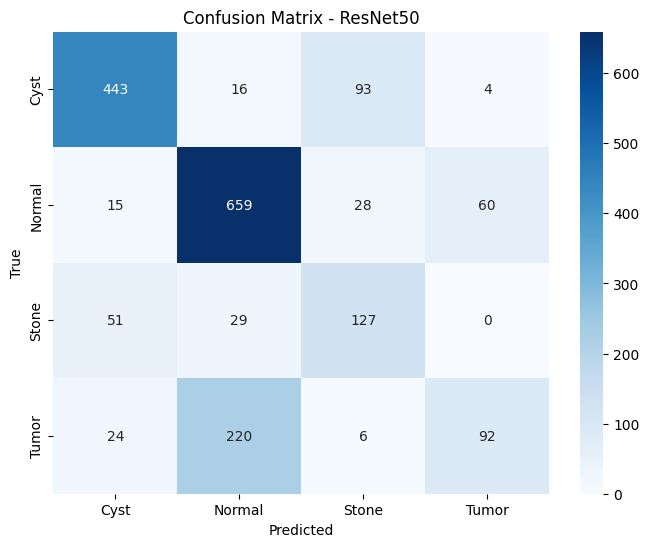


Classification Report - ResNet50:
              precision    recall  f1-score   support

        Cyst       0.83      0.80      0.81       556
      Normal       0.71      0.86      0.78       762
       Stone       0.50      0.61      0.55       207
       Tumor       0.59      0.27      0.37       342

    accuracy                           0.71      1867
   macro avg       0.66      0.64      0.63      1867
weighted avg       0.70      0.71      0.69      1867



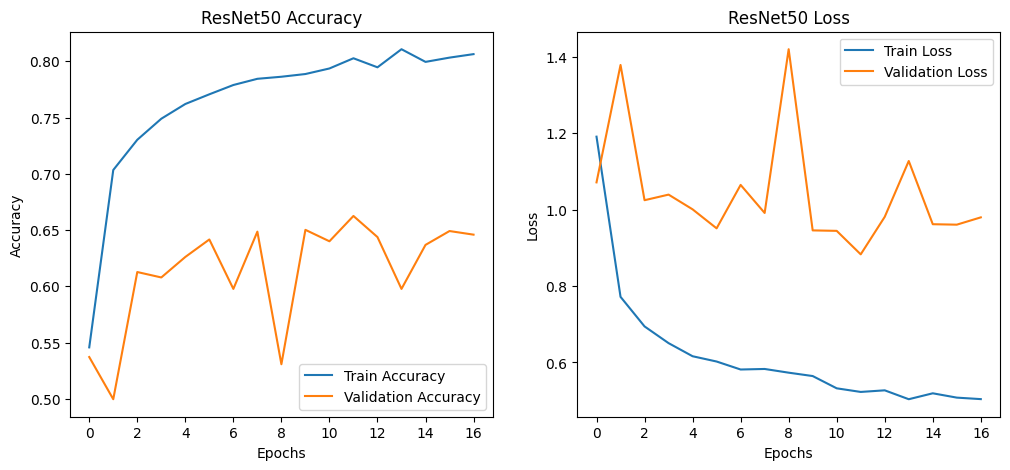

In [12]:
# --- Evaluate Model 2 ---
print("\n--- Evaluating Transfer Learning Model (ResNet50) ---")
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_ds_rgb_prefetched)
print(f"Test Accuracy: {test_acc_resnet:.2f}")

# --- Plotting and Reporting for Model 2 ---
y_true_resnet, y_pred_resnet = [], []
for x, y in test_ds_rgb_prefetched:
    preds = resnet_model.predict(x)
    y_true_resnet.extend(y.numpy())
    y_pred_resnet.extend(np.argmax(preds, axis=1))

cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet50")
plt.show()

print("\nClassification Report - ResNet50:")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ResNet50 Loss")
plt.legend()
plt.show()


In [13]:
# MODEL 3: HYBRID MODEL (ResNet50 + EfficientNetV2B0)
# =========================================================
# --- Build Hybrid Model ---
inputs_hybrid = layers.Input(shape=(224, 224, 3))

# ResNet50 branch
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet.trainable = False
x_resnet = resnet_preprocess(inputs_hybrid)
features_resnet = base_resnet(x_resnet, training=False)
features_resnet = layers.GlobalAveragePooling2D()(features_resnet)

# EfficientNetV2B0 branch
base_efficient = efficientnet_v2.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_efficient.trainable = False
x_efficient = efficientnet_v2.preprocess_input(inputs_hybrid) # Use EfficientNetV2 specific preprocessing
features_efficient = base_efficient(x_efficient, training=False)
features_efficient = layers.GlobalAveragePooling2D()(features_efficient)

# Concatenate features
concatenated_features = layers.concatenate([features_resnet, features_efficient])

# Classification head
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated_features)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x) # Higher dropout for a more complex head
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs_hybrid = layers.Dense(num_classes, activation='softmax')(x)

hybrid_model = models.Model(inputs=inputs_hybrid, outputs=outputs_hybrid)

# Compile
hybrid_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
hybrid_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ input_layer_6[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ input_layer_6[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ input_layer_6[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 7, 7,      │  5,919,312 │ input_layer_6[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3328)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    852,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4)         │        516 │ dropout_8[0][0] 

 Total params: 30,394,196 (115.94 MB)

 Trainable params: 886,404 (3.38 MB)

 Non-trainable params: 29,507,792 (112.56 MB)

In [14]:
# --- Train Model 3 ---
print("\n--- Training Hybrid Model (ResNet50 + EfficientNetV2B0) ---")
history_hybrid = hybrid_model.fit(
    train_ds_rgb_prefetched,
    validation_data=val_ds_rgb_prefetched,
    epochs=25,
    class_weight=class_weights,
    callbacks=callbacks
)


--- Training Hybrid Model (ResNet50 + EfficientNetV2B0) ---
Epoch 1/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.5824 - loss: 2.4678 - val_accuracy: 0.4853 - val_loss: 1.8838 - learning_rate: 0.0010
Epoch 2/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 264s 966ms/step - accuracy: 0.7014 - loss: 1.0617 - val_accuracy: 0.5463 - val_loss: 1.2642 - learning_rate: 0.0010
Epoch 3/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 260s 951ms/step - accuracy: 0.7321 - loss: 0.8804 - val_accuracy: 0.4269 - val_loss: 1.7079 - learning_rate: 0.0010
Epoch 4/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 259s 949ms/step - accuracy: 0.7598 - loss: 0.7472 - val_accuracy: 0.5485 - val_loss: 1.1480 - learning_rate: 5.0000e-04
Epoch 5/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.7758 - loss: 0.6879 - val_accuracy: 0.5292 - val_loss: 1.3617 - learning_rate: 5.0000e-04



--- Evaluating Hybrid Model ---
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 568ms/step - accuracy: 0.5292 - loss: 1.4781
Test Accuracy: 0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━

2025-09-27 23:09:33.763771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


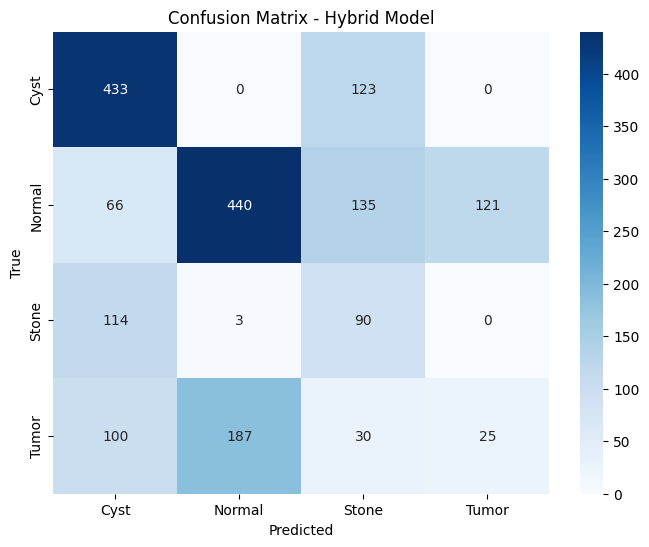


Classification Report - Hybrid Model:
              precision    recall  f1-score   support

        Cyst       0.61      0.78      0.68       556
      Normal       0.70      0.58      0.63       762
       Stone       0.24      0.43      0.31       207
       Tumor       0.17      0.07      0.10       342

    accuracy                           0.53      1867
   macro avg       0.43      0.47      0.43      1867
weighted avg       0.52      0.53      0.51      1867



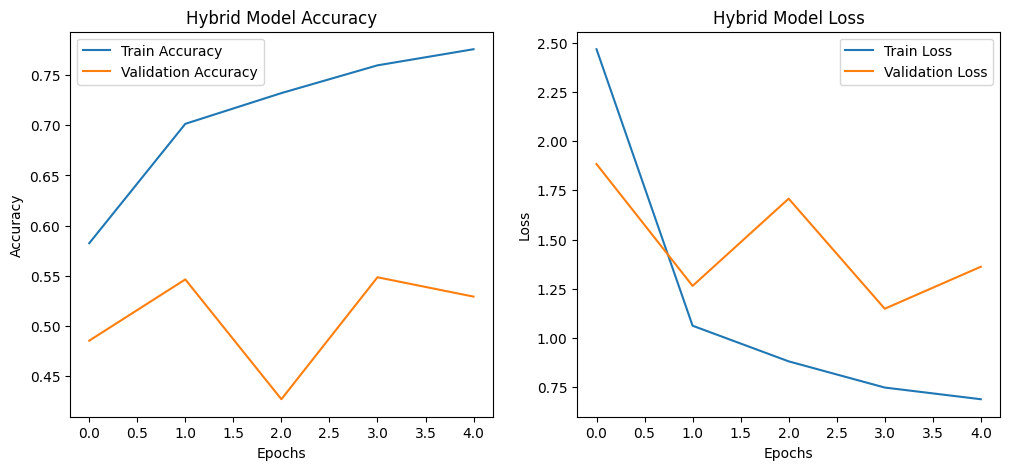

In [15]:
# --- Evaluate Model 3 ---
print("\n--- Evaluating Hybrid Model ---")
test_loss_hybrid, test_acc_hybrid = hybrid_model.evaluate(test_ds_rgb_prefetched)
print(f"Test Accuracy: {test_acc_hybrid:.2f}")

# --- Plotting and Reporting for Model 3 ---
y_true_hybrid, y_pred_hybrid = [], []
for x, y in test_ds_rgb_prefetched:
    preds = hybrid_model.predict(x)
    y_true_hybrid.extend(y.numpy())
    y_pred_hybrid.extend(np.argmax(preds, axis=1))

cm_hybrid = confusion_matrix(y_true_hybrid, y_pred_hybrid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()

print("\nClassification Report - Hybrid Model:")
print(classification_report(y_true_hybrid, y_pred_hybrid, target_names=class_names))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Hybrid Model Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Hybrid Model Loss")
plt.legend()
plt.show()

In [16]:
# 1) IMPORT LIBRARIES
# =========================================================
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications import efficientnet_v2

In [17]:
# 2) SET PATHS AND PARAMETERS
# =========================================================
DATASET_DIR = '/Users/aishwarysinghrathour/Desk/Data Sets/Kidney Dataset' # Use your path

train_dir = os.path.join(DATASET_DIR, "train")
val_dir   = os.path.join(DATASET_DIR, "valid")
test_dir  = os.path.join(DATASET_DIR, "test")

img_size = (224, 224)
batch_size = 32


In [18]:
# 3) DATA PREPARATION PIPELINE (FOR TRANSFER LEARNING)
# =========================================================
AUTOTUNE = tf.data.AUTOTUNE

# --- Load grayscale datasets ---
train_ds_gray = image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)
val_ds_gray = image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)
test_ds_gray = image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)

class_names = train_ds_gray.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# --- Map grayscale images to RGB for compatibility ---
def grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds_rgb = train_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE)
val_ds_rgb = val_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE)
test_ds_rgb = test_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE)

# --- More Aggressive Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),  # Increased rotation
    layers.RandomZoom(0.3),   # Increased zoom
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.3), # Added brightness
])

# --- Apply Augmentation and Prefetching ---
def prepare_dataset(dataset, training=False):
    if training:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return dataset.prefetch(buffer_size=AUTOTUNE)

train_ds_final = prepare_dataset(train_ds_rgb, training=True)
val_ds_final = prepare_dataset(val_ds_rgb)
test_ds_final = prepare_dataset(test_ds_rgb)

# --- Compute Class Weights ---
all_labels = np.concatenate([y for x, y in train_ds_gray], axis=0)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Found 8712 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Class Weights: {0: 0.8386599922988063, 1: 0.6130030959752322, 2: 2.2616822429906542, 3: 1.3621013133208255}


2025-09-27 23:21:00.308139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
# 4) BUILD ADVANCED MODEL (EfficientNetV2B0 with Fine-Tuning)
# =========================================================
def build_finetune_model(input_shape, num_classes):
    # --- Base Model (Frozen) ---
    base_model = efficientnet_v2.EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False # Freeze the base

    # --- Model Architecture ---
    inputs = layers.Input(shape=input_shape)
    x = efficientnet_v2.preprocess_input(inputs) # Preprocessing layer
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) # Strong dropout
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model, base_model

# --- Build the model ---
finetune_model, base_model = build_finetune_model(img_size + (3,), num_classes)

# --- Callbacks ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

In [21]:
# 5) PHASE 1: FEATURE EXTRACTION TRAINING
# =========================================================
print("\n--- PHASE 1: Training the Classification Head ---")
finetune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_feature_extract = finetune_model.fit(
    train_ds_final,
    validation_data=val_ds_final,
    epochs=50, # Give it enough epochs, EarlyStopping will handle it
    class_weight=class_weights,
    callbacks=callbacks
)



--- PHASE 1: Training the Classification Head ---
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 93s 300ms/step - accuracy: 0.5240 - loss: 1.4143 - val_accuracy: 0.5694 - val_loss: 1.2507 - learning_rate: 0.0010
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 67s 243ms/step - accuracy: 0.6059 - loss: 1.0631 - val_accuracy: 0.5533 - val_loss: 1.3087 - learning_rate: 0.0010
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 101s 367ms/step - accuracy: 0.6381 - loss: 0.9694 - val_accuracy: 0.6599 - val_loss: 1.1703 - learning_rate: 0.0010
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 79s 286ms/step - accuracy: 0.6421 - loss: 0.9324 - val_accuracy: 0.6679 - val_loss: 1.1115 - learning_rate: 0.0010
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 71s 258ms/step - accuracy: 0.6422 - loss: 0.9357 - val_accuracy: 0.6047 - val_loss: 1.2685 - learning_rate: 0.0010
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 85s 311ms/step - accuracy: 0.6506 - loss: 0.9345 - val_accuracy: 0.6127 - val_loss: 1.2397 - learning_rate: 0.0010
Epoch 7/50
273/273

In [22]:
# 6) PHASE 2: FINE-TUNING
# =========================================================
print("\n--- PHASE 2: Fine-Tuning the Top Layers ---")
# --- Unfreeze some top layers of the base model ---
base_model.trainable = True
for layer in base_model.layers[:-20]: # Keep the bottom layers frozen
    layer.trainable = False

# --- Re-compile with a VERY LOW learning rate ---
finetune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Crucial low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
finetune_model.summary()

# --- Continue training (fine-tuning) ---
history_finetune = finetune_model.fit(
    train_ds_final,
    validation_data=val_ds_final,
    epochs=30, # Allow more epochs for fine-tuning
    initial_epoch=history_feature_extract.epoch[-1] + 1,
    class_weight=class_weights,
    callbacks=callbacks
)



--- PHASE 2: Fine-Tuning the Top Layers ---


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,254,420 (23.86 MB)

 Trainable params: 1,149,876 (4.39 MB)

 Non-trainable params: 5,104,544 (19.47 MB)

Epoch 10/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 136s 430ms/step - accuracy: 0.6379 - loss: 0.9533 - val_accuracy: 0.6706 - val_loss: 1.1412 - learning_rate: 1.0000e-05
Epoch 11/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 103s 374ms/step - accuracy: 0.6556 - loss: 0.9263 - val_accuracy: 0.6642 - val_loss: 1.1551 - learning_rate: 1.0000e-05
Epoch 12/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 114s 416ms/step - accuracy: 0.6608 - loss: 0.9040 - val_accuracy: 0.6497 - val_loss: 1.1875 - learning_rate: 2.0000e-06
Epoch 13/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 96s 347ms/step - accuracy: 0.6591 - loss: 0.9153 - val_accuracy: 0.6668 - val_loss: 1.1365 - learning_rate: 2.0000e-06
Epoch 14/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 109s 394ms/step - accuracy: 0.6608 - loss: 0.9036 - val_accuracy: 0.6679 - val_loss: 1.1677 - learning_rate: 1.0000e-06



--- Evaluating Final Fine-Tuned Model ---
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 0.6535 - loss: 0.9991
Final Test Accuracy: 0.6535
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/s

2025-09-28 00:19:33.748989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

        Cyst       0.96      0.59      0.73       556
      Normal       0.68      0.92      0.78       762
       Stone       0.38      0.82      0.52       207
       Tumor       0.51      0.07      0.12       342

    accuracy                           0.65      1867
   macro avg       0.63      0.60      0.54      1867
weighted avg       0.70      0.65      0.62      1867



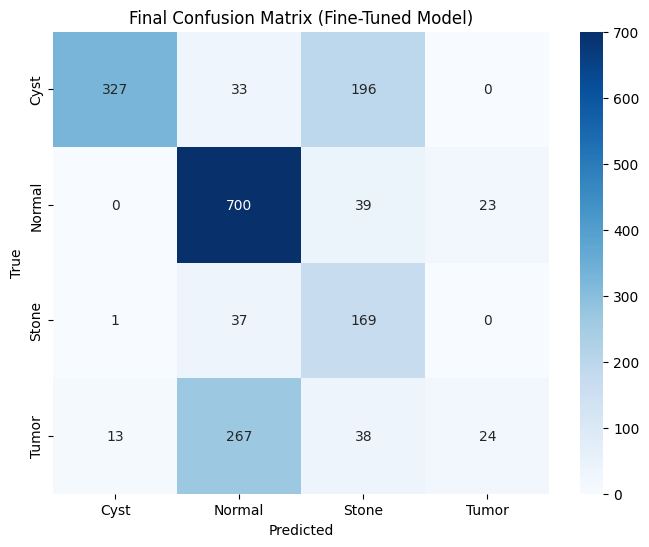

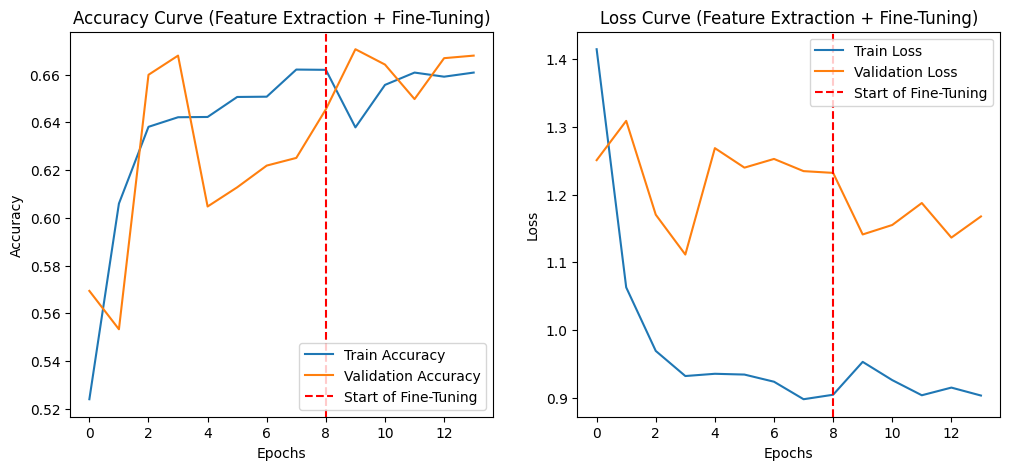

In [23]:
# 7) FINAL EVALUATION AND REPORTING
# =========================================================
print("\n--- Evaluating Final Fine-Tuned Model ---")
test_loss, test_acc = finetune_model.evaluate(test_ds_final)
print(f"Final Test Accuracy: {test_acc:.4f}")

# --- Plotting and Reporting ---
y_true, y_pred = [], []
for x, y in test_ds_final:
    preds = finetune_model.predict(x)
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# --- Classification Report ---
print("\nFinal Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Confusion Matrix (Fine-Tuned Model)")
plt.show()

# --- Plot Combined Training Curves ---
def plot_combined_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history1.epoch)-1, color='r', linestyle='--', label='Start of Fine-Tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve (Feature Extraction + Fine-Tuning)')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(x=len(history1.epoch)-1, color='r', linestyle='--', label='Start of Fine-Tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve (Feature Extraction + Fine-Tuning)')
    
    plt.show()

plot_combined_history(history_feature_extract, history_finetune)

In [1]:
# 1) IMPORT LIBRARIES
# =========================================================
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications import ResNet50V2, EfficientNetV2B2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess

# =========================================================

In [2]:
# 2) SET PATHS AND PARAMETERS
# =========================================================
DATASET_DIR = '/Users/aishwarysinghrathour/Desk/Data Sets/Kidney Dataset' # Use your path

train_dir = os.path.join(DATASET_DIR, "train")
val_dir   = os.path.join(DATASET_DIR, "valid")
test_dir  = os.path.join(DATASET_DIR, "test")

img_size = (224, 224)
batch_size = 32


In [3]:
# 3) DATA PREPARATION PIPELINE
# =========================================================
AUTOTUNE = tf.data.AUTOTUNE

# --- Load grayscale datasets ---
train_ds_gray = image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)
val_ds_gray = image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)
test_ds_gray = image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)

class_names = train_ds_gray.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# --- Map grayscale to RGB ---
def grayscale_to_rgb(image, label):
    return tf.image.grayscale_to_rgb(image), label

train_ds_rgb = train_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE)
val_ds_rgb = val_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE)
test_ds_rgb = test_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE)

# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
])

# --- Apply Augmentation and Prefetching ---
def prepare_dataset(dataset, training=False):
    if training:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return dataset.prefetch(buffer_size=AUTOTUNE)

train_ds_final = prepare_dataset(train_ds_rgb, training=True)
val_ds_final = prepare_dataset(val_ds_rgb)
test_ds_final = prepare_dataset(test_ds_rgb)

# --- Compute Class Weights ---
all_labels = np.concatenate([y for x, y in train_ds_gray], axis=0)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Found 8712 files belonging to 4 classes.


2025-09-30 08:24:03.284380: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-30 08:24:03.284627: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-30 08:24:03.284634: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-30 08:24:03.284924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-30 08:24:03.284971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 1867 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Class Weights: {0: 0.8386599922988063, 1: 0.6130030959752322, 2: 2.2616822429906542, 3: 1.3621013133208255}


2025-09-30 08:24:11.486824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# 4) BUILD THE FINAL HYBRID FINE-TUNING MODEL
# =========================================================
def build_final_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # --- Branch 1: ResNet50V2 ---
    base_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_resnet.trainable = False
    x_resnet = resnet_v2_preprocess(inputs)
    features_resnet = base_resnet(x_resnet, training=False)
    features_resnet = layers.GlobalAveragePooling2D(name='resnet_gap')(features_resnet)

    # --- Branch 2: EfficientNetV2B2 ---
    base_efficientnet = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_efficientnet.trainable = False
    x_efficientnet = efficientnet_v2_preprocess(inputs)
    features_efficientnet = base_efficientnet(x_efficientnet, training=False)
    features_efficientnet = layers.GlobalAveragePooling2D(name='efficientnet_gap')(features_efficientnet)
    
    # --- Concatenate Features ---
    concatenated_features = layers.concatenate([features_resnet, features_efficientnet], name='concatenate')
    
    # --- Classification Head ---
    x = layers.BatchNormalization()(concatenated_features)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model, base_resnet, base_efficientnet

# --- Build the model ---
final_model, base1, base2 = build_final_model(img_size + (3,), num_classes)

In [5]:
# 5) PHASE 1: FEATURE EXTRACTION TRAINING
# =========================================================
print("\n--- PHASE 1: Training the Classification Head ---")
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train for a few epochs to let the new head stabilize
history_feature_extract = final_model.fit(
    train_ds_final,
    validation_data=val_ds_final,
    epochs=10,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)



--- PHASE 1: Training the Classification Head ---
Epoch 1/10


2025-09-30 08:24:18.815335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


273/273 ━━━━━━━━━━━━━━━━━━━━ 301s 999ms/step - accuracy: 0.6659 - loss: 1.1046 - val_accuracy: 0.6315 - val_loss: 1.0272
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 247s 899ms/step - accuracy: 0.7439 - loss: 0.8102 - val_accuracy: 0.6808 - val_loss: 0.9885
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 229s 837ms/step - accuracy: 0.7746 - loss: 0.7210 - val_accuracy: 0.6422 - val_loss: 1.0464
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 240s 875ms/step - accuracy: 0.7851 - loss: 0.6944 - val_accuracy: 0.6508 - val_loss: 1.0469
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 242s 881ms/step - accuracy: 0.7895 - loss: 0.6948 - val_accuracy: 0.6363 - val_loss: 1.1267


In [6]:
# 6) PHASE 2: FINE-TUNING
# =========================================================
print("\n--- PHASE 2: Fine-Tuning the Top Layers of Both Models ---")
# --- Unfreeze top layers ---
base1.trainable = True
for layer in base1.layers[:-30]:
    layer.trainable = False
    
base2.trainable = True
for layer in base2.layers[:-30]:
    layer.trainable = False

# --- Re-compile with a VERY LOW learning rate ---
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Low LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
final_model.summary()


--- PHASE 2: Fine-Tuning the Top Layers of Both Models ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ subtract[0][0]    │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b2   │ (None, 7, 7,      │  8,769,374 │ input_layer_1[0]… │
│ (Functional)        │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_gap          │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnet_gap    │ (None, 1408)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3456)      │          0 │ resnet_gap[0][0], │
│ (Concatenate)       │                   │            │ efficientnet_gap… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 3456)      │     13,824 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3456)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,769,984 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      2,052 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,122,082 (130.17 MB)

 Trainable params: 17,590,892 (67.10 MB)

 Non-trainable params: 16,531,190 (63.06 MB)

In [8]:
# --- Continue training ---
history_finetune = final_model.fit(
    train_ds_final,
    validation_data=val_ds_final,
    epochs=25, # More epochs for fine-tuning
    initial_epoch=history_feature_extract.epoch[-1] + 1,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 6/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.8543 - loss: 0.4921 - val_accuracy: 0.6449 - val_loss: 1.1184
Epoch 7/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.8767 - loss: 0.4346 - val_accuracy: 0.6679 - val_loss: 1.0369
Epoch 8/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.9019 - loss: 0.3828 - val_accuracy: 0.6995 - val_loss: 1.0007
Epoch 9/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.9149 - loss: 0.3466 - val_accuracy: 0.7027 - val_loss: 0.9963
Epoch 10/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.9248 - loss: 0.3177 - val_accuracy: 0.6915 - val_loss: 1.0530
Epoch 11/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.9310 - loss: 0.3034 - val_accuracy: 0.7317 - val_loss: 0.9656
Epoch 12/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 530s 2s/step - accuracy: 0.9395 - loss: 0.2738 - val_accuracy: 0.7220 - val_loss: 1.0034
Epoch 13/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.9479 - loss: 0.2610 - val_


--- Evaluating Final Fine-Tuned Model ---
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 914ms/step - accuracy: 0.7338 - loss: 0.9152
Final Test Accuracy: 0.7338
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━

2025-10-02 10:30:37.096792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

        Cyst       0.99      0.65      0.79       556
      Normal       0.76      0.91      0.83       762
       Stone       0.49      0.97      0.65       207
       Tumor       0.64      0.33      0.43       342

    accuracy                           0.73      1867
   macro avg       0.72      0.72      0.67      1867
weighted avg       0.77      0.73      0.72      1867



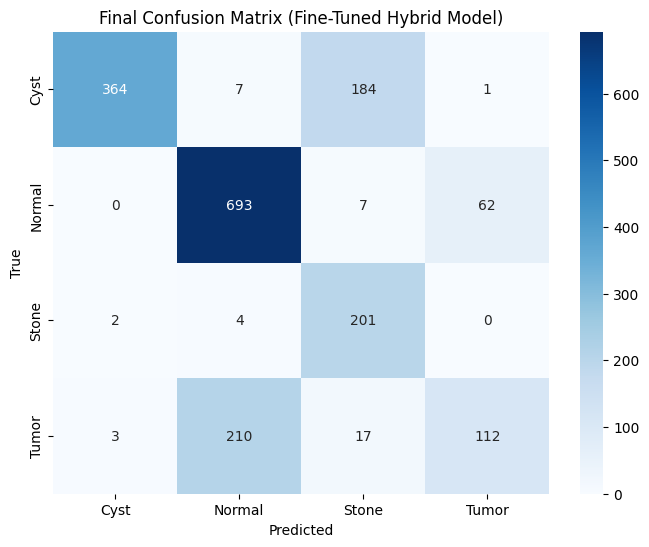

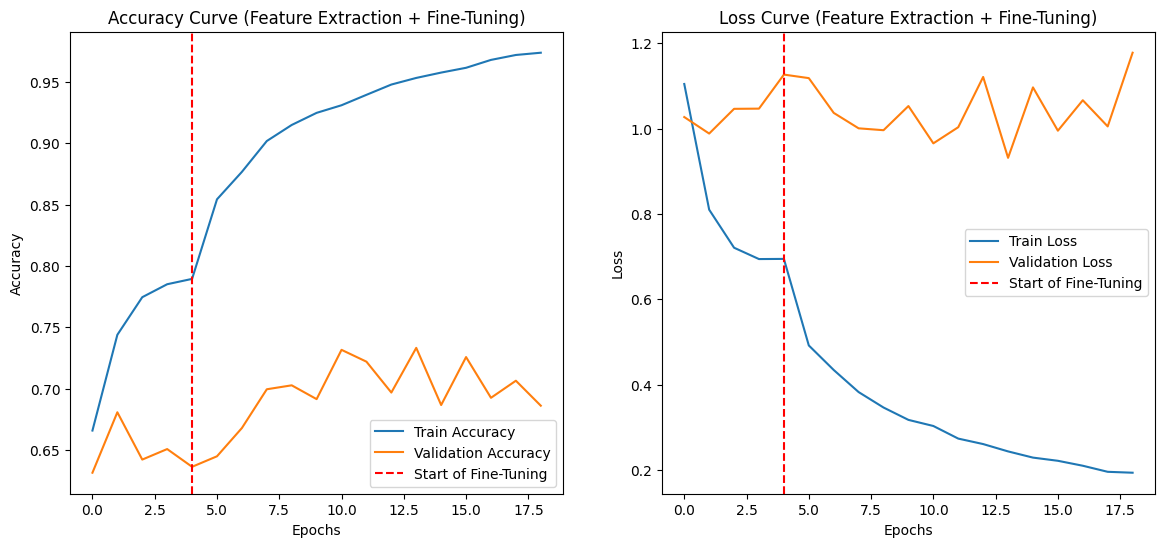

In [9]:
# 7) FINAL EVALUATION AND REPORTING
# =========================================================
print("\n--- Evaluating Final Fine-Tuned Model ---")
test_loss, test_acc = final_model.evaluate(test_ds_final)
print(f"Final Test Accuracy: {test_acc:.4f}")

# --- Plotting and Reporting ---
y_true, y_pred = [], []
for x, y in test_ds_final:
    preds = final_model.predict(x)
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# --- Classification Report ---
print("\nFinal Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Confusion Matrix (Fine-Tuned Hybrid Model)")
plt.show()

# --- Plot Combined Training Curves ---
def plot_combined_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history1.epoch)-1, color='r', linestyle='--', label='Start of Fine-Tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve (Feature Extraction + Fine-Tuning)')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(x=len(history1.epoch)-1, color='r', linestyle='--', label='Start of Fine-Tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve (Feature Extraction + Fine-Tuning)')
    
    plt.show()

plot_combined_history(history_feature_extract, history_finetune)

## lets see


In [18]:
# 1) IMPORT LIBRARIES
# =========================================================
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications import ResNet50V2, EfficientNetV2B2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess

In [19]:
# 2) SET PATHS AND PARAMETERS
# =========================================================
DATASET_DIR = '/Users/aishwarysinghrathour/Desk/Data Sets/Kidney Dataset' # Use your path

train_dir = os.path.join(DATASET_DIR, "train")
val_dir   = os.path.join(DATASET_DIR, "valid")
test_dir  = os.path.join(DATASET_DIR, "test")

img_size = (224, 224)
batch_size = 32


In [20]:
# 3) DATA PREPARATION WITH OVERSAMPLING (CORRECTED)
# =========================================================
AUTOTUNE = tf.data.AUTOTUNE

# --- Load the full training, validation, and test datasets in grayscale ---
train_ds_gray = image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)
val_ds_gray = image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)
test_ds_gray = image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)

class_names = train_ds_gray.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# --- CORRECTED OVERSAMPLING STRATEGY ---
# 1. Unbatch the dataset BEFORE filtering
train_ds_unbatched = train_ds_gray.unbatch()

# 2. Filter the unbatched dataset for each class
datasets_by_class = [
    train_ds_unbatched.filter(lambda x, y: y == i) for i in range(num_classes)
]

# 3. Create a balanced training dataset by sampling equally
# The `.repeat()` is now applied to the individual class datasets to make them "infinite" for sampling
resampling_datasets = [ds.repeat() for ds in datasets_by_class]

train_ds_balanced = tf.data.experimental.sample_from_datasets(
    resampling_datasets, weights=[1/num_classes] * num_classes
)

# --- Map grayscale to RGB and apply augmentation ---
def grayscale_to_rgb(image, label):
    return tf.image.grayscale_to_rgb(image), label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomBrightness(0.2),
])

# 4. Build the final training pipeline (shuffle, map, batch, prefetch)
train_ds_final = train_ds_balanced.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE) \
                                .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE) \
                                .batch(batch_size) \
                                .prefetch(buffer_size=AUTOTUNE)

# --- Prepare validation and test sets (no oversampling or augmentation) ---
val_ds_final = val_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
test_ds_final = test_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

Found 8712 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [21]:
# =========================================================
# 3) DATA PREPARATION WITH OVERSAMPLING (CORRECTED & SIMPLIFIED)
# =========================================================
AUTOTUNE = tf.data.AUTOTUNE

# --- Load the full training, validation, and test datasets in grayscale ---
# We load the training data WITHOUT shuffling initially to make filtering easier.
train_ds_gray = image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int", shuffle=False
)
val_ds_gray = image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)
test_ds_gray = image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, color_mode="grayscale", label_mode="int"
)

class_names = train_ds_gray.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# --- CORRECTED OVERSAMPLING STRATEGY ---
# 1. Unbatch the dataset BEFORE filtering. This is the crucial fix.
train_ds_unbatched = train_ds_gray.unbatch()

# 2. Filter the unbatched dataset for each class.
#    The lambda function now correctly receives a single (image, label) pair.
datasets_by_class = [
    train_ds_unbatched.filter(lambda image, label: label == i) for i in range(num_classes)
]

# 3. Create a balanced training dataset by sampling equally.
#    The .repeat() makes each class dataset "infinite" for sampling purposes.
resampling_datasets = [ds.repeat() for ds in datasets_by_class]

train_ds_balanced = tf.data.experimental.sample_from_datasets(
    resampling_datasets, weights=[1/num_classes] * num_classes
)

# --- Define the mapping functions ---
def grayscale_to_rgb(image, label):
    return tf.image.grayscale_to_rgb(image), label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomBrightness(0.2),
])

def apply_augmentation(image, label):
    return data_augmentation(image, training=True), label

# 4. Build the final training pipeline
#    Now we apply shuffling, mapping, and batching to the balanced dataset.
train_ds_final = train_ds_balanced.shuffle(1000) \
                                .map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE) \
                                .map(apply_augmentation, num_parallel_calls=AUTOTUNE) \
                                .batch(batch_size) \
                                .prefetch(buffer_size=AUTOTUNE)

# --- Prepare validation and test sets (no oversampling or augmentation) ---
val_ds_final = val_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
test_ds_final = test_ds_gray.map(grayscale_to_rgb, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

print("\nData preparation pipeline has been corrected and is ready for training.")

Found 8712 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Found 1867 files belonging to 4 classes.
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']

Data preparation pipeline has been corrected and is ready for training.


In [22]:
# 4) BUILD THE FINAL HYBRID FINE-TUNING MODEL
# =========================================================
def build_final_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    base_efficientnet = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_efficientnet.trainable = False
    x_efficientnet = efficientnet_v2_preprocess(inputs)
    features_efficientnet = base_efficientnet(x_efficientnet, training=False)
    features_efficientnet = layers.GlobalAveragePooling2D(name='efficientnet_gap')(features_efficientnet)
    
    base_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_resnet.trainable = False
    x_resnet = resnet_v2_preprocess(inputs)
    features_resnet = base_resnet(x_resnet, training=False)
    features_resnet = layers.GlobalAveragePooling2D(name='resnet_gap')(features_resnet)
    
    concatenated_features = layers.concatenate([features_efficientnet, features_resnet], name='concatenate')
    
    x = layers.BatchNormalization()(concatenated_features)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model, base_efficientnet, base_resnet

final_model, base1, base2 = build_final_model(img_size + (3,), num_classes)


In [23]:
# 5) PHASE 1: FEATURE EXTRACTION TRAINING
# =========================================================
print("\n--- PHASE 1: Training the Classification Head on Balanced Data ---")
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_feature_extract = final_model.fit(
    train_ds_final,
    validation_data=val_ds_final,
    epochs=15,
    steps_per_epoch=len(train_ds_gray),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
)


--- PHASE 1: Training the Classification Head on Balanced Data ---
Epoch 1/15


2025-10-02 10:46:07.836793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:983: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-10-02 10:46:08.829071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.6734 - loss: 1.1707 - val_accuracy: 0.5222 - val_loss: 1.4474
Epoch 2/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.7123 - loss: 0.9301 - val_accuracy: 0.5919 - val_loss: 1.0507
Epoch 3/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.7239 - loss: 0.8351 - val_accuracy: 0.5303 - val_loss: 1.3870
Epoch 4/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.7487 - loss: 0.7966 - val_accuracy: 0.6010 - val_loss: 1.1708
Epoch 5/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.7432 - loss: 0.7904 - val_accuracy: 0.5828 - val_loss: 1.1199
Epoch 6/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.7658 - loss: 0.7556 - val_accuracy: 0.6513 - val_loss: 1.1608


In [24]:
# 6) PHASE 2: CONSERVATIVE FINE-TUNING
# =========================================================
print("\n--- PHASE 2: Fine-Tuning the Top Layers of Both Models ---")
base1.trainable = True
for layer in base1.layers[:-15]:
    layer.trainable = False
    
base2.trainable = True
for layer in base2.layers[:-15]:
    layer.trainable = False

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
final_model.summary()

history_finetune = final_model.fit(
    train_ds_final,
    validation_data=val_ds_final,
    epochs=30, 
    steps_per_epoch=len(train_ds_gray),
    initial_epoch=history_feature_extract.epoch[-1] + 1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)



--- PHASE 2: Fine-Tuning the Top Layers of Both Models ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_1       │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 224, 224,  │          0 │ true_divide_1[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b2   │ (None, 7, 7,      │  8,769,374 │ input_layer_6[0]… │
│ (Functional)        │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ subtract_1[0][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnet_gap    │ (None, 1408)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_gap          │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3456)      │          0 │ efficientnet_gap… │
│ (Concatenate)       │                   │            │ resnet_gap[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3456)      │     13,824 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3456)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  1,769,984 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      2,052 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,122,082 (130.17 MB)

 Trainable params: 7,999,832 (30.52 MB)

 Non-trainable params: 26,122,250 (99.65 MB)

Epoch 7/30


2025-10-02 13:16:55.791716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:983: Filling up shuffle buffer (this may take a while): 12 of 1000
2025-10-02 13:16:56.673620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 ━━━━━━━━━━━━━━━━━━━━ 746s 3s/step - accuracy: 0.7234 - loss: 0.8776 - val_accuracy: 0.6283 - val_loss: 1.0154
Epoch 8/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.7262 - loss: 0.8588 - val_accuracy: 0.6304 - val_loss: 1.0058
Epoch 9/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.7337 - loss: 0.8428 - val_accuracy: 0.6283 - val_loss: 1.0551
Epoch 10/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 707s 3s/step - accuracy: 0.7601 - loss: 0.7667 - val_accuracy: 0.6443 - val_loss: 1.0357
Epoch 11/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.7547 - loss: 0.7489 - val_accuracy: 0.6711 - val_loss: 0.9798
Epoch 12/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.7901 - loss: 0.6741 - val_accuracy: 0.6813 - val_loss: 0.9558
Epoch 13/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.7898 - loss: 0.6793 - val_accuracy: 0.6572 - val_loss: 1.0255
Epoch 14/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.7922 - loss: 0.6664 - val_accuracy: 


--- Evaluating Final Fine-Tuned Model ---
59/59 ━━━━━━━━━━━━━━━━━━━━ 49s 663ms/step - accuracy: 0.6851 - loss: 1.2370
Final Test Accuracy: 0.6851
1/1 ━━━━━━━━━━━━━━━━━━━━ 92s 92s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step

2025-10-03 08:36:36.306147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


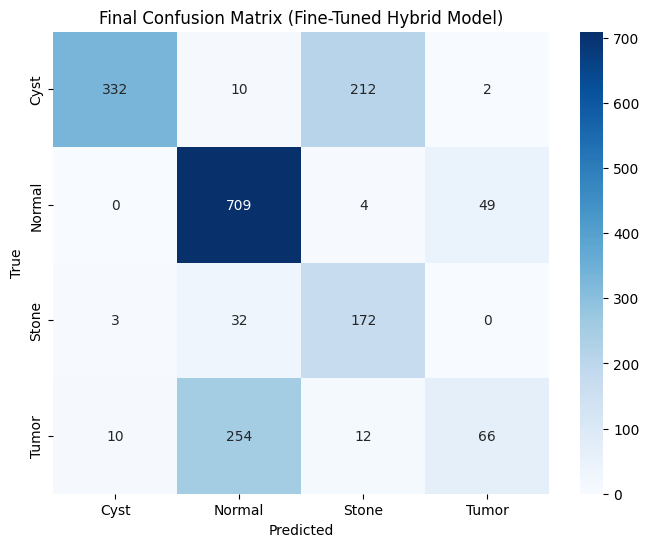

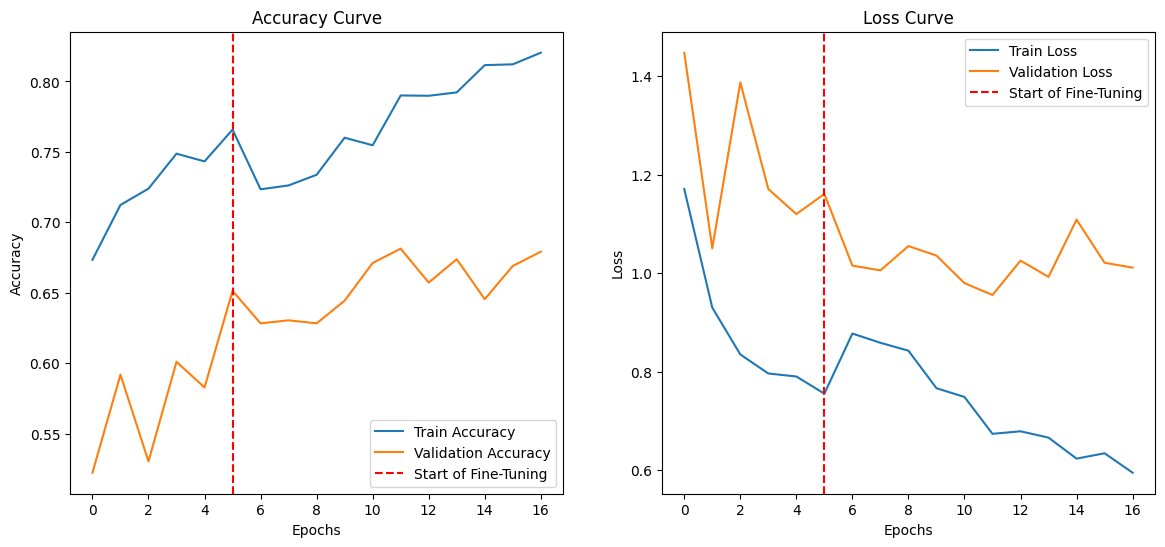

In [25]:
# 7) FINAL EVALUATION AND REPORTING
# =========================================================
print("\n--- Evaluating Final Fine-Tuned Model ---")
test_loss, test_acc = final_model.evaluate(test_ds_final)
print(f"Final Test Accuracy: {test_acc:.4f}")

# (The rest of the evaluation and plotting code remains the same)
y_true, y_pred = [], []
for x, y in test_ds_final:
    preds = final_model.predict(x)
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nFinal Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Confusion Matrix (Fine-Tuned Hybrid Model)")
plt.show()

def plot_combined_history(history1, history2):
    acc = history1.history.get('accuracy', []) + history2.history.get('accuracy', [])
    val_acc = history1.history.get('val_accuracy', []) + history2.history.get('val_accuracy', [])
    loss = history1.history.get('loss', []) + history2.history.get('loss', [])
    val_loss = history1.history.get('val_loss', []) + history2.history.get('val_loss', [])
    
    if not acc: # Check if history is empty
        print("No training history to plot.")
        return

    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history1.epoch)-1, color='r', linestyle='--', label='Start of Fine-Tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(x=len(history1.epoch)-1, color='r', linestyle='--', label='Start of Fine-Tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    
    plt.show()

plot_combined_history(history_feature_extract, history_finetune)